## Import Libraries 

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import statistics
import random
%matplotlib inline
plt.style.use('bmh')

In [2]:
from keras.preprocessing.image import ImageDataGenerator

2023-04-26 19:17:51.110199: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from skimage import exposure
from skimage.feature import local_binary_pattern
from skimage.util import img_as_ubyte
from skimage.feature import graycomatrix, graycoprops

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [5]:
import h5py

## Load data

In [6]:
h5f = h5py.File('data_h5','r')

denim_blended = h5f['denim_blended'][:]
denim = h5f['denim'][:]

knit_blended = h5f['knit_blended'][:]
knit = h5f['knit'][:]

fleece_blended = h5f['fleece_blended'][:]
fleece_poly = h5f['fleece_poly'][:]
fleece_Modal = h5f['fleece_Modal'][:]

linen = h5f['linen'][:]
linen_rayon = h5f['linen_rayon'][:]
linen_viscose = h5f['linen_viscose'][:]

leather_poly = h5f['leather_poly'][:]
leather_PU = h5f['leather_PU'][:]
leather_PVC = h5f['leather_PVC'][:]

outdoor_cotton = h5f['outdoor_cotton'][:]
outdoor_poly = h5f['outdoor_poly'][:]

# Preprocess Data 

### 1. Augment data

In [7]:
#should be np array (#imgs, pixel,pixel,3) for RGB scale
def rotate_imgs (fabric, num_imgs, angle_start, angle_stop): 
    
    pixels = len(fabric[1,:,:,0]) 
    fabric_aug = np.zeros((num_imgs,pixels,pixels,3))
    
    for i in range(num_imgs): 
        angle = random.randint(angle_start, angle_stop)
        # ImageDataGenerator rotation
        datagen = ImageDataGenerator(rotation_range=angle, fill_mode='nearest')
        # iterator
        aug_iter = datagen.flow(fabric, batch_size=1)
        # generate one img with random angle
        image = next(aug_iter)[0].astype('uint8')
        fabric_aug[i,:,:,:] = image
 
    return fabric_aug

In [8]:
#should be np array (#imgs, pixel,pixel,1) for grey scale
def shift_imgs (fabric, num_imgs, width_shift, height_shift): 
    
    pixels = len(fabric[1,:,:,0]) 
    fabric_aug = np.zeros((num_imgs,pixels,pixels,3))
    
    for i in range(num_imgs): 
        width_shift = random.uniform(0.01, width_shift)
        height_shift = random.uniform(0.01, height_shift)
        # ImageDataGenerator rotation
        datagen = ImageDataGenerator(width_shift_range=width_shift, height_shift_range=height_shift)
        # iterator
        aug_iter = datagen.flow(fabric, batch_size=1)
        # generate one img with random angle
        image = next(aug_iter)[0].astype('uint8')
        fabric_aug[i,:,:,:] = image
 
    return fabric_aug

In [9]:
#should be np array (#imgs, pixel,pixel,1) for grey scale
def flip_imgs (fabric, num_imgs): 
    
    pixels = len(fabric[1,:,:,0]) 
    fabric_aug = np.zeros((num_imgs,pixels,pixels,3))
    
    for i in range(num_imgs): 
        # ImageDataGenerator rotation
        datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
        # iterator
        aug_iter = datagen.flow(fabric, batch_size=1)
        # generate one img with random angle
        image = next(aug_iter)[0].astype('uint8')
        fabric_aug[i,:,:,:] = image
 
    return fabric_aug

In [10]:
#should be np array (#imgs, pixel,pixel,1) for grey scale
def zoom_imgs (fabric, num_imgs, start_range, stop_range): 
    
    pixels = len(fabric[1,:,:,0]) 
    fabric_aug = np.zeros((num_imgs,pixels,pixels,3))
    
    for i in range(num_imgs): 
        zoom = random.uniform(start_range,stop_range)
        #stop = random.uniform(start_range+.01, stop_range)
        # ImageDataGenerator rotation
        datagen = ImageDataGenerator(zoom_range=zoom)
        # iterator
        aug_iter = datagen.flow(fabric, batch_size=1)
        # generate one img with random angle
        image = next(aug_iter)[0].astype('uint8')
        fabric_aug[i,:,:,:] = image
 
    return fabric_aug

In [11]:
# method to create transofrmations (including rotations, shifts, zooms, and flips for 5 imgs of each data type)
def transform_fabric(fabric):
    
    num_imgs = 5
    pixels = len(fabric[1,:,:,0])
    
    rotate = rotate_imgs(fabric, num_imgs, -45, 45)
    shift = shift_imgs(fabric, num_imgs, 0.2, 0.2)
    flip = flip_imgs(fabric, num_imgs)
    zoom = zoom_imgs(fabric, num_imgs, 0.05, 1)
    
    transform = np.zeros((4*num_imgs,pixels,pixels,3))
    #df_transform = pd.DataFrame()
    i = 0
    j = 0
    while j<(4*num_imgs):
        #df_transform = pd.concat([df_transform,df1,df2,df3,df4])
        transform[j,:,:] = rotate[i]
        transform[j+1,:,:] = shift[i]
        transform[j+2,:,:] = flip[i]
        transform[j+3,:,:] = zoom[i]
        j+=4
        i+=1
       
    return transform


### Add augmented data 

In [12]:
denim_blended_aug = transform_fabric(denim_blended)
denim_blended = np.vstack((denim_blended_aug, denim_blended))
denim_aug = transform_fabric(denim)
denim = np.vstack((denim, denim_aug))

knit_blended_aug = transform_fabric(knit_blended)
knit_blended = np.vstack((knit_blended_aug, knit_blended))
knit_aug = transform_fabric(knit)
knit = np.vstack((knit, knit_aug))

fleece_blended_aug = transform_fabric(fleece_blended)
fleece_blended = np.vstack((fleece_blended_aug, fleece_blended))
fleece_poly_aug = transform_fabric(fleece_poly)
fleece_poly = np.vstack((fleece_poly, fleece_poly_aug))
fleece_Modal_aug = transform_fabric(fleece_Modal)
fleece_Modal = np.vstack((fleece_Modal, fleece_Modal_aug))

linen_aug = transform_fabric(linen)
linen_blended = np.vstack((linen_aug, linen))
linen_rayon_aug = transform_fabric(linen_rayon)
linen_rayon = np.vstack((linen_rayon, linen_rayon_aug))
linen_viscose_aug = transform_fabric(linen_viscose)
linen_viscose = np.vstack((linen_viscose, linen_viscose_aug))

leather_poly_aug = transform_fabric(leather_poly)
leather_poly = np.vstack((leather_poly_aug, leather_poly))
leather_PU_aug = transform_fabric(leather_PU)
leather_PU = np.vstack((leather_PU, leather_PU_aug))
leather_PVC_aug = transform_fabric(leather_PVC)
leather_PVC = np.vstack((leather_PVC, leather_PVC_aug))

outdoor_cotton_aug = transform_fabric(outdoor_cotton)
outdoor_cotton = np.vstack((outdoor_cotton, outdoor_cotton_aug))
outdoor_poly_aug = transform_fabric(outdoor_poly)
outdoor_poly = np.vstack((outdoor_poly, outdoor_poly_aug))

### Enhance images with histogram equlaization 

In [13]:
# makes rbg images gray images (for single image)
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [14]:
# turns whole fabric dataset to gray images (for multiple imgs)
def create_gray_imgs(fabric):
    num_imgs = len(fabric)
    gray = np.zeros((num_imgs, 224, 224))
    for i in range(num_imgs):
        gray[i,:,:] = rgb2gray(fabric[i,:,:,:])
    return gray 

In [15]:
# use adaptive histogram equalization to enhance local contrast (single image)

def equalize_img(image): 
    image = rgb2gray(image)
    image = image/255
    img_adapteq = exposure.equalize_adapthist(image, clip_limit=0.03) #tried clip_limit=[0.1-1.0] (0.5 was best) too grainy if you go up very soft going down 
    
    return img_adapteq

In [16]:
# use adaptive histogram equalization to enhance local contrast (entrie fabric)

def equalize_fabric(fabric): 
    N,p,p,c = fabric.shape 
    equalized = np.zeros((N,p,p))
    for n in range(N):
        image = fabric[n,:,:,:]
        equalized[n,:,:] = equalize_img(image)
        
    return equalized

In [17]:
# create equlaized images for each fabric type 

denim_eq = equalize_fabric(denim)
denim_b_eq = equalize_fabric(denim_blended)


knit_eq = equalize_fabric(knit)
knit_b_eq = equalize_fabric(knit_blended)


fleece_blended_eq = equalize_fabric(fleece_blended)
fleece_poly_eq = equalize_fabric(fleece_poly)
fleece_Modal_eq = equalize_fabric(fleece_Modal)


linen_eq = equalize_fabric(linen)
linen_rayon_eq = equalize_fabric(linen_rayon)
linen_viscose_eq = equalize_fabric(linen_viscose)


leather_poly_eq = equalize_fabric(leather_poly)
leather_PU_eq = equalize_fabric(leather_PU)
leather_PVC_eq = equalize_fabric(leather_PVC)


outdoor_cotton_eq = equalize_fabric(outdoor_cotton)
outdoor_poly_eq = equalize_fabric(outdoor_poly)

Text(0.5, 1.0, 'equalized')

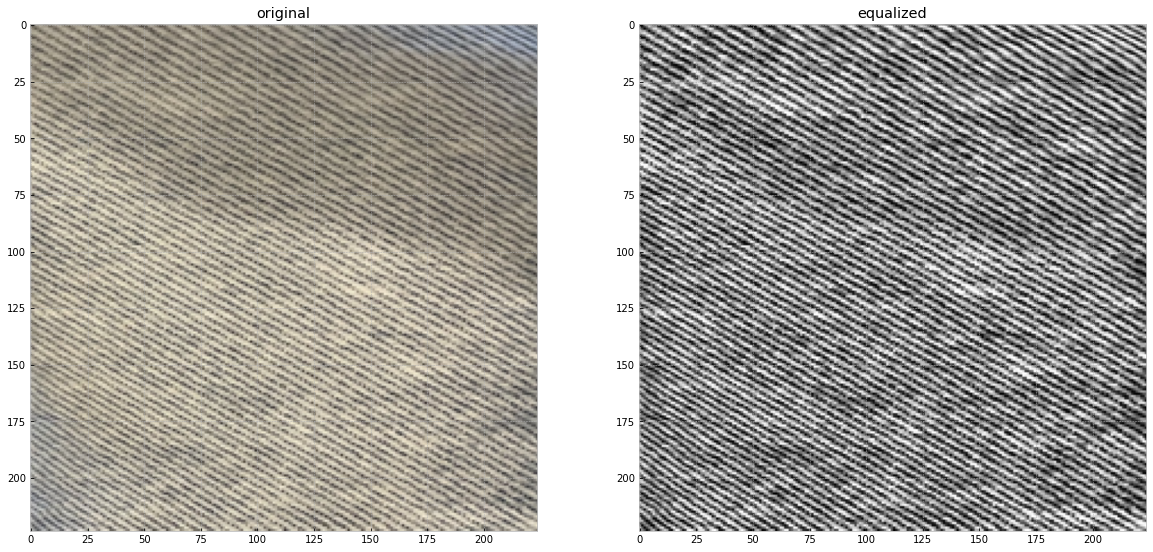

In [18]:
#plot example image 
index = 1

fabric = denim
fabric_eq =denim_eq

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(fabric[index,:,:,:]/255)
plt.title('original')
plt.subplot(1,2,2)
plt.imshow(fabric_eq[index,:,:], cmap = 'gray')
plt.title('equalized')


## Combine data 


In [19]:
# create lables for each fabric type 
def create_labels(fabric, label):
    images = len(fabric)
    labels = np.zeros((images))
    for i in range(images):
        labels[i] = label
        
    return labels

In [20]:
# combine fabrics and labels (combine denims, leathers, etc)

def create_data_matrix_eq(num_fabrics,fabric1,fabric2,fabric3,fabric4): 
    
    # create labels 
    fabric1_labels = create_labels(fabric1,0)
    fabric2_labels = create_labels(fabric2,1)
    
    if num_fabrics ==2: 
        X = np.vstack((fabric1, fabric2))
        Y = np.hstack((fabric1_labels, fabric2_labels))
    
    elif num_fabrics == 3: 
        fabric3_labels = create_labels(fabric3,2)
        X = np.vstack((fabric1, fabric2, fabric3))
        Y = np.hstack((fabric1_labels, fabric2_labels, fabric3_labels))
  
    return X, Y 
    

In [21]:
X_fleece, Y_fleece = create_data_matrix_eq(3,fleece_blended_eq,fleece_poly_eq[0:90,:,:],fleece_Modal_eq,0)
X_knit, Y_knit = create_data_matrix_eq(2,knit_b_eq, knit_eq, 0, 0)
X_linen, Y_linen = create_data_matrix_eq(3,linen_eq,linen_rayon_eq, linen_viscose_eq,0)
X_leather, Y_leather = create_data_matrix_eq(3,leather_poly_eq,leather_PU_eq, leather_PVC_eq, 0)
X_outdoor, Y_outdoor = create_data_matrix_eq(2,outdoor_cotton_eq,outdoor_poly_eq, 0,0)
X_denim, Y_denim = create_data_matrix_eq(2,denim_eq,denim_b_eq, 0,0)

# Feature Extraction

### 1. LBP histograms  

In [22]:
# create lbp for an image 
def lbp_image(images,num_points,radius):
    lbps = []
    N, p, p = images.shape
    for n in range(N):
        lbp = local_binary_pattern(images[n,:,:], P=num_points, R=radius)
        lbps.append(lbp)
    
    return np.array(lbps)

In [23]:
def create_sub_images(image, num_sub_imgs): #divides image into 16 sub images 
    pixel, pixel = image.shape
    total_imgs = round(num_sub_imgs**2)
    sub_pixels = round(pixel/num_sub_imgs)
    start_row = 0
    stop_row = start_row + sub_pixels
    start_col = 0
    stop_col = start_col +  sub_pixels
    row = 0 
    sub_imgs = np.zeros((total_imgs,sub_pixels,sub_pixels))
    for i in range(total_imgs-1):
        width = pixel/num_sub_imgs
        sub_imgs[i,:,:] = image[start_row:stop_row,start_col:stop_col]
        #change row 
        if stop_col ==224: 
            row = row+1 
            start_col = 0
            stop_col = start_col +  sub_pixels
            start_row = row*(sub_pixels)
            stop_row = start_row + sub_pixels 
        else: 
            start_col = start_col+sub_pixels
            stop_col= stop_col + sub_pixels
            
    return sub_imgs

In [24]:
# creates histogram for each sub image 
def create_histograms(fabric,num_sub_imgs,bins_per_sub_images): 
    N,p,p = fabric.shape
    fabric_hist = np.zeros((N,round(bins_per_sub_images*num_sub_imgs*num_sub_imgs)))
    for n in range(N):
        image = fabric[n,:,:]
        sub_imgs = create_sub_images(image, num_sub_imgs)
        sub_img_hist = []
        for i in range(round(num_sub_imgs**2)): 
            histogram = np.histogram(sub_imgs[i,:,:], bins=bins_per_sub_images)[0]
            sub_img_hist.append(histogram)
            
        hist1 = np.array(sub_img_hist).flatten()
        fabric_hist[n,:] = hist1
    
    return fabric_hist

In [25]:
# creates lbp histogram for each sub image for all images 
def lbp_histograms(fabric, num_points, radius, num_sub_imgs, num_bins):
    lbp = lbp_image(fabric,num_points,radius)
    lbp_hist = create_histograms(lbp, num_sub_imgs, num_bins)
    
    return lbp_hist

### 2. GLCM

In [26]:
# creates GLCM for each sub image 
def GLCM_sub_imgs(sub_images, dist, angle): 
    sub_images = img_as_ubyte(sub_images/255)
    num_images, pixel, pixel = sub_images.shape
    contrast = []
    dissimilarity = []
    homogeneity = []
    ASM = []
    energy = []
    correlation = []
    for i in range(num_images): 
        glcm = graycomatrix(sub_images[i,:,:], distances = dist, angles = angle, levels = 256,
                       symmetric = True, normed = True)
        contrast.append(graycoprops(glcm, 'contrast'))
        dissimilarity.append(graycoprops(glcm, 'dissimilarity'))
        homogeneity.append(graycoprops(glcm, 'homogeneity'))
        ASM.append(graycoprops(glcm, 'ASM'))
        energy.append(graycoprops(glcm, 'energy'))
        correlation.append(graycoprops(glcm, 'correlation'))
    
    return contrast, dissimilarity, homogeneity, ASM, energy, correlation

In [27]:
# creates GLCM for all the images in a fabric type (needs to be in grey scale)
def GLCM_fabric(fabric, num_sub_imgs, dist, angle):
    N, pixels, pixels = fabric.shape
    properties = np.zeros((N,6,round(num_sub_imgs**2)))
    for n in range(N): 
        image = fabric[n, :, :]
        sub_imgs = create_sub_images(image, num_sub_imgs)
        contrast, dissimilarity, homogeneity, ASM, energy, correlation = GLCM_sub_imgs(sub_imgs,dist,angle)
        for i in range(round(num_sub_imgs**2)): 
            properties[n,0,i]=contrast[i]
            properties[n,1,i]=dissimilarity[i]
            properties[n,2,i]=homogeneity[i]
            properties[n,3,i]= ASM[i]
            properties[n,4,i]= energy[i]
            properties[n,5,i]=correlation[i]
    
    return properties

## 3. combine features 

In [28]:
def fabric_features(X, Y, numpoints, radius): 
    
    #split data 
    X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=0.2,
                                                    random_state=42,
                                                       stratify = Y)
    
    #create lbp histograms 
    X_train_lbp = lbp_histograms(X_train, numpoints, radius, num_sub_imgs = 4, num_bins = 64) #tried 10 bins, 40 bins, 56 and 64 (drastically increased) 
    X_test_lbp = lbp_histograms(X_test, numpoints, radius, num_sub_imgs = 4, num_bins = 64)
    
    #create GCLM features 
    X_train_prop = GLCM_fabric(X_train, num_sub_imgs = 4, dist = [2], angle = [0])
    N,K,L = X_train_prop.shape
    X_train_prop = X_train_prop.reshape((N,K*L))
    X_test_prop = GLCM_fabric(X_test, num_sub_imgs = 4, dist = [2] , angle = [0])
    N,K,L = X_test_prop.shape
    X_test_prop = X_test_prop.reshape((N,K*L))
    
    #combine features 
    X_train = np.hstack((X_train_lbp,X_train_prop))
    X_test = np.hstack((X_test_lbp,X_test_prop))
    
    return X_train, X_test, y_train, y_test 

In [29]:
#fabric_features(X, Y, numpoints, radius)
X_train_fleece, X_test_fleece, Y_train_fleece, Y_test_fleece = fabric_features(X_fleece, Y_fleece,8,1)
X_train_knit, X_test_knit, Y_train_knit, Y_test_knit = fabric_features(X_knit, Y_knit,8,1)
X_train_linen, X_test_linen, Y_train_linen, Y_test_linen = fabric_features(X_linen, Y_linen,8,1)
X_train_leather, X_test_leather, Y_train_leather, Y_test_leather = fabric_features(X_leather, Y_leather,8,1)
X_train_outdoor, X_test_outdoor, Y_train_outdoor, Y_test_outdoor = fabric_features(X_outdoor, Y_outdoor,8,1)
X_train_denim, X_test_denim, Y_train_denim, Y_test_denim = fabric_features(X_denim, Y_denim,8,1)

## PCA 

In [30]:
# code is adapted from lecture about PCA, finds the number of features necessary for 92% vairance creates new matric wiht only key features 
def find_key_features(X_train,X_test,Y_train,N_features_start): 
    N, fet = X_train.shape
    N_features = N_features_start
    check = 0
    while check<1:
    
        # Designing and training dimensionality reduction model
        pipe = Pipeline([('scaler', StandardScaler()),
                ('pca', PCA(n_components=N))])

        pipe.fit(X_train, Y_train)

        explained_var = np.cumsum(pipe.named_steps['pca'].explained_variance_ratio_)[N_features]

        if explained_var>=0.92: 
            check = 2
            pipe = Pipeline([('scaler', StandardScaler()),
                ('pca', PCA(n_components=N_features))])
            pipe.fit(X_train, Y_train)
            ypca = pipe.transform(X_train)
            ypca_test = pipe.transform(X_test)
        else: 
            check = 0
            N_features = N_features+2
            
    return N_features, ypca, ypca_test

In [31]:
N_feat_fleece, X_train_fleece, X_test_fleece = find_key_features(X_train_fleece, X_test_fleece, Y_train_fleece,100)
N_feat_knit, X_train_knit, X_test_knit = find_key_features(X_train_knit, X_test_knit, Y_train_knit,50)
N_feat_linen, X_train_linen, X_test_linen = find_key_features(X_train_linen, X_test_linen, Y_train_linen,50)
N_feat_leather, X_train_leather, X_test_leather = find_key_features(X_train_leather, X_test_leather, Y_train_leather,50)
N_feat_outdoor, X_train_outdoor, X_test_outdoor = find_key_features(X_train_outdoor, X_test_outdoor, Y_train_outdoor,50)
N_feat_denim, X_train_denim, X_test_denim = find_key_features(X_train_denim, X_test_denim, Y_train_denim,10)

In [32]:
N_feat_fleece,N_feat_knit,N_feat_linen,N_feat_leather,N_feat_outdoor,N_feat_denim

(120, 56, 78, 72, 118, 32)

## train classifiers

In [33]:
def train_Models(X_train_hist, X_test_hist, y_train, y_test, neighbors, solver, penalty, c, kernel): 
    
    ###SVM 
    model_svm = SVC(C = c, kernel = kernel, probability = True)
    model_svm.fit(X_train_hist, y_train)
    predicted = model_svm.predict(X_test_hist)
    svm_train = model_svm.score(X_train_hist, y_train)
    svm_test = model_svm.score(X_test_hist, y_test)
    f1_svm = f1_score(y_test,predicted, average=None)
    N, col = model_svm.predict_proba(X_test_hist).shape
    if col==2: 
        svm_ROC = roc_auc_score(y_test, model_svm.predict_proba(X_test_hist)[:, 1])
    else:
        svm_ROC = roc_auc_score(y_test, model_svm.predict_proba(X_test_hist), multi_class='ovo')
    
    ### logistic regression
    model_logreg = LogisticRegression(max_iter=5000, penalty = penalty, solver = solver)
    model_logreg.fit(X_train_hist, y_train)
    predicted = model_logreg.predict(X_test_hist)
    lr_train = model_logreg.score(X_train_hist, y_train)
    lr_test = model_logreg.score(X_test_hist, y_test)
    f1_lr = f1_score(y_test,predicted, average=None)
    N, col = model_logreg.predict_proba(X_test_hist).shape
    if col==2: 
        lr_ROC = roc_auc_score(y_test, model_logreg.predict_proba(X_test_hist)[:, 1])
    else:
        lr_ROC = roc_auc_score(y_test, model_logreg.predict_proba(X_test_hist), multi_class='ovo')
    
    
    ### KNN
    model_knn = KNeighborsClassifier(n_neighbors=neighbors)
    model_knn.fit(X_train_hist, y_train)
    predicted = model_knn.predict(X_test_hist)
    knn_train = model_knn.score(X_train_hist, y_train)
    knn_test =  model_knn.score(X_test_hist, y_test)
    f1_knn = f1_score(y_test,predicted, average=None)
    if col==2: 
        ROC_knn = roc_auc_score(y_test, model_knn.predict_proba(X_test_hist)[:, 1])
    else:
        ROC_knn = roc_auc_score(y_test, model_knn.predict_proba(X_test_hist), multi_class='ovo')
    
    
    
    return svm_train, svm_test, f1_svm, svm_ROC, lr_train, lr_test, f1_lr, lr_ROC, knn_train, knn_test, f1_knn, ROC_knn

In [34]:
svm_train, svm_test, f1_svm, svm_ROC,lr_train, lr_test, f1_lr, lr_ROC, knn_train, knn_test, f1_knn, ROC_knn = train_Models(
                                                                                                        X_train_fleece, 
                                                                                                        X_test_fleece, 
                                                                                                        Y_train_fleece, 
                                                                                                        Y_test_fleece,
                                                                                                        neighbors = 1,
                                                                                                        solver = 'lbfgs',
                                                                                                        penalty = 'l2',
                                                                                                        c = 1,
                                                                                                        kernel = 'linear')

print ('fleece\t:')
print('')
print('SVM train acc\t:', svm_train)
print('SVM test acc\t:', svm_test)
print('SVM F1 score\t:', f1_svm)
print('SVM ROC auc\t:', svm_ROC)
print('')
print('logistic regression train acc\t:', lr_train)
print('logistic regression test acc\t:', lr_test)
print('logistic regression F1 score\t:', f1_lr)
print('logisitc regression ROC auc\t:', lr_ROC)
print('')
print('KNN train acc\t:', knn_train)
print('KNN test acc\t:', knn_test)
print('KNN F1 score\t:',  f1_knn)
print('KNN ROC auc\t:', ROC_knn)

fleece	:

SVM train acc	: 1.0
SVM test acc	: 0.8936170212765957
SVM F1 score	: [0.88888889 0.91891892 0.85714286]
SVM ROC auc	: 0.9625420875420875

logistic regression train acc	: 1.0
logistic regression test acc	: 0.8936170212765957
logistic regression F1 score	: [0.88888889 0.94736842 0.8       ]
logisitc regression ROC auc	: 0.9527684249906473

KNN train acc	: 1.0
KNN test acc	: 0.8936170212765957
KNN F1 score	: [0.91891892 0.92307692 0.77777778]
KNN ROC auc	: 0.8952020202020202


In [35]:
svm_train, svm_test, f1_svm, svm_ROC,lr_train, lr_test, f1_lr, lr_ROC, knn_train, knn_test, f1_knn, ROC_knn = train_Models(
                                                                                                                X_train_knit, 
                                                                                                                X_test_knit, 
                                                                                                                Y_train_knit, 
                                                                                                                Y_test_knit,
                                                                                                                neighbors = 1,
                                                                                                                solver = 'lbfgs',
                                                                                                                penalty = 'l2',
                                                                                                                c = 1, 
                                                                                                                kernel = 'sigmoid')

print ('knit\t:')
print('')
print('SVM train acc\t:', svm_train)
print('SVM test acc\t:', svm_test)
print('SVM F1 score\t:', f1_svm)
print('SVM ROC auc\t:', svm_ROC)
print('')
print('logistic regression train acc\t:', lr_train)
print('logistic regression test acc\t:', lr_test)
print('logistic regression F1 score\t:', f1_lr)
print('logisitc regression ROC auc\t:', lr_ROC)
print('')
print('KNN train acc\t:', knn_train)
print('KNN test acc\t:', knn_test)
print('KNN F1 score\t:',  f1_knn)
print('KNN ROC auc\t:', ROC_knn)

knit	:

SVM train acc	: 0.9863013698630136
SVM test acc	: 1.0
SVM F1 score	: [1. 1.]
SVM ROC auc	: 1.0

logistic regression train acc	: 1.0
logistic regression test acc	: 1.0
logistic regression F1 score	: [1. 1.]
logisitc regression ROC auc	: 1.0

KNN train acc	: 1.0
KNN test acc	: 1.0
KNN F1 score	: [1. 1.]
KNN ROC auc	: 1.0


In [36]:
svm_train, svm_test, f1_svm, svm_ROC,lr_train, lr_test, f1_lr, lr_ROC, knn_train, knn_test, f1_knn, ROC_knn = train_Models(
                                                                                                                X_train_linen,
                                                                                                                X_test_linen, 
                                                                                                                Y_train_linen, 
                                                                                                                Y_test_linen,
                                                                                                                neighbors = 3,
                                                                                                                solver = 'lbfgs',
                                                                                                                penalty = 'l2',
                                                                                                                c = 10,
                                                                                                                kernel = 'rbf')

print ('linen\t:')
print('')
print('SVM train acc\t:', svm_train)
print('SVM test acc\t:', svm_test)
print('SVM F1 score\t:', f1_svm)
print('SVM ROC auc\t:', svm_ROC)
print('')
print('logistic regression train acc\t:', lr_train)
print('logistic regression test acc\t:', lr_test)
print('logistic regression F1 score\t:', f1_lr)
print('logisitc regression ROC auc\t:', lr_ROC)
print('')
print('KNN train acc\t:', knn_train)
print('KNN test acc\t:', knn_test)
print('KNN F1 score\t:',  f1_knn)
print('KNN ROC auc\t:', ROC_knn)

linen	:

SVM train acc	: 1.0
SVM test acc	: 1.0
SVM F1 score	: [1. 1. 1.]
SVM ROC auc	: 1.0

logistic regression train acc	: 1.0
logistic regression test acc	: 0.8918918918918919
logistic regression F1 score	: [0.90909091 0.88888889 0.88888889]
logisitc regression ROC auc	: 0.9528478057889821

KNN train acc	: 0.9591836734693877
KNN test acc	: 0.8378378378378378
KNN F1 score	: [0.90909091 0.84848485 0.8       ]
KNN ROC auc	: 0.9082633053221288


In [37]:
svm_train, svm_test, f1_svm, svm_ROC,lr_train, lr_test, f1_lr, lr_ROC, knn_train, knn_test, f1_knn, ROC_knn = train_Models(
                                                                                                                X_train_leather, 
                                                                                                                X_test_leather, 
                                                                                                                Y_train_leather, 
                                                                                                                Y_test_leather, 
                                                                                                                neighbors = 2,
                                                                                                                solver = 'liblinear',
                                                                                                                penalty = 'l2',
                                                                                                                c = 3,
                                                                                                                kernel = 'rbf')

print ('leather\t:')
print('')
print('SVM train acc\t:', svm_train)
print('SVM test acc\t:', svm_test)
print('SVM F1 score\t:', f1_svm)
print('SVM ROC auc\t:', svm_ROC)
print('')
print('logistic regression train acc\t:', lr_train)
print('logistic regression test acc\t:', lr_test)
print('logistic regression F1 score\t:', f1_lr)
print('logisitc regression ROC auc\t:', lr_ROC)
print('')
print('KNN train acc\t:', knn_train)
print('KNN test acc\t:', knn_test)
print('KNN F1 score\t:',  f1_knn)
print('KNN ROC auc\t:', ROC_knn)

leather	:

SVM train acc	: 1.0
SVM test acc	: 0.8857142857142857
SVM F1 score	: [0.88       0.94736842 0.84615385]
SVM ROC auc	: 0.984090909090909

logistic regression train acc	: 1.0
logistic regression test acc	: 0.8285714285714286
logistic regression F1 score	: [0.83333333 0.8        0.84615385]
logisitc regression ROC auc	: 0.9300865800865802

KNN train acc	: 0.9197080291970803
KNN test acc	: 0.8285714285714286
KNN F1 score	: [0.8        0.77777778 0.88888889]
KNN ROC auc	: 0.9560064935064935


In [38]:
svm_train, svm_test, f1_svm, svm_ROC,lr_train, lr_test, f1_lr, lr_ROC, knn_train, knn_test, f1_knn, ROC_knn = train_Models(
                                                                                                            X_train_outdoor,
                                                                                                            X_test_outdoor, 
                                                                                                            Y_train_outdoor, 
                                                                                                            Y_test_outdoor, 
                                                                                                            neighbors = 1,
                                                                                                            solver = 'lbfgs',
                                                                                                            penalty = 'l2',
                                                                                                            c =1, 
                                                                                                            kernel = 'sigmoid')

print ('Outdoor Fabric\t:')
print('')
print('SVM train acc\t:', svm_train)
print('SVM test acc\t:', svm_test)
print('SVM F1 score\t:', f1_svm)
print('SVM ROC auc\t:', svm_ROC)
print('')
print('logistic regression train acc\t:', lr_train)
print('logistic regression test acc\t:', lr_test)
print('logistic regression F1 score\t:', f1_lr)
print('logisitc regression ROC auc\t:', lr_ROC)
print('')
print('KNN train acc\t:', knn_train)
print('KNN test acc\t:', knn_test)
print('KNN F1 score\t:',  f1_knn)
print('KNN ROC auc\t:', ROC_knn)

Outdoor Fabric	:

SVM train acc	: 0.9776119402985075
SVM test acc	: 0.9702970297029703
SVM F1 score	: [0.98224852 0.90909091]
SVM ROC auc	: 0.9798449612403102

logistic regression train acc	: 1.0
logistic regression test acc	: 0.9801980198019802
logistic regression F1 score	: [0.98823529 0.9375    ]
logisitc regression ROC auc	: 0.9968992248062015

KNN train acc	: 1.0
KNN test acc	: 0.9405940594059405
KNN F1 score	: [0.96590909 0.76923077]
KNN ROC auc	: 0.8275193798449612


In [39]:
svm_train, svm_test, f1_svm, svm_ROC,lr_train, lr_test, f1_lr, lr_ROC, knn_train, knn_test, f1_knn, ROC_knn = train_Models(
                                                                                                                X_train_denim, 
                                                                                                                X_test_denim, 
                                                                                                                Y_train_denim, 
                                                                                                                Y_test_denim, 
                                                                                                                neighbors = 3,
                                                                                                                solver = 'lbfgs',
                                                                                                                penalty = 'l2',
                                                                                                                c = 1,
                                                                                                                kernel = 'rbf')

print ('Denim Fabric\t:')
print('')
print('SVM train acc\t:', svm_train)
print('SVM test acc\t:', svm_test)
print('SVM F1 score\t:', f1_svm)
print('SVM ROC auc\t:', svm_ROC)
print('')
print('logistic regression train acc\t:', lr_train)
print('logistic regression test acc\t:', lr_test)
print('logistic regression F1 score\t:', f1_lr)
print('logisitc regression ROC auc\t:', lr_ROC)
print('')
print('KNN train acc\t:', knn_train)
print('KNN test acc\t:', knn_test)
print('KNN F1 score\t:',  f1_knn)
print('KNN ROC auc\t:', ROC_knn)

Denim Fabric	:

SVM train acc	: 1.0
SVM test acc	: 0.9473684210526315
SVM F1 score	: [0.95238095 0.94117647]
SVM ROC auc	: 1.0

logistic regression train acc	: 1.0
logistic regression test acc	: 0.8421052631578947
logistic regression F1 score	: [0.85714286 0.82352941]
logisitc regression ROC auc	: 0.9111111111111112

KNN train acc	: 0.958904109589041
KNN test acc	: 0.9473684210526315
KNN F1 score	: [0.94736842 0.94736842]
KNN ROC auc	: 0.9444444444444444
